# **TEAM: INSIGHT STRATEGISTS**
# **Sentiment Analysis of Customer Reviews in Zomato Bangalore Restaurants**


In [ ]:
#importing required libraries
import json
import re

import numpy as np 
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [ ]:
tqdm.pandas()

# Data Pre-processing:

In [ ]:
#reading the dataset
from google.colab import drive
drive.mount("/content/drive")

zomato_orgnl = pd.read_csv('/content/drive/MyDrive/zomato.csv')
zomato_orgnl.head()

Mounted at /content/drive


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
#deleting Unnnecessary Columns
zomato=zomato_orgnl.drop(['url','dish_liked','phone'],axis=1)

In [ ]:
#removing the Duplicates
zomato.duplicated().sum()
zomato.drop_duplicates(inplace=True)

In [ ]:
#remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   address                      43499 non-null  object
 1   name                         43499 non-null  object
 2   online_order                 43499 non-null  object
 3   book_table                   43499 non-null  object
 4   rate                         43499 non-null  object
 5   votes                        43499 non-null  int64 
 6   location                     43499 non-null  object
 7   rest_type                    43499 non-null  object
 8   cuisines                     43499 non-null  object
 9   approx_cost(for two people)  43499 non-null  object
 10  reviews_list                 43499 non-null  object
 11  menu_item                    43499 non-null  object
 12  listed_in(type)              43499 non-null  object
 13  listed_in(city)              43

In [ ]:
#changing the Columns Names
zomato.columns
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
zomato.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [ ]:
#some transformations on 'cost'
zomato['cost'] = zomato['cost'].astype(str)
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.'))
zomato['cost'] = zomato['cost'].astype(float)
zomato.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       43499 non-null  object 
 1   name          43499 non-null  object 
 2   online_order  43499 non-null  object 
 3   book_table    43499 non-null  object 
 4   rate          43499 non-null  object 
 5   votes         43499 non-null  int64  
 6   location      43499 non-null  object 
 7   rest_type     43499 non-null  object 
 8   cuisines      43499 non-null  object 
 9   cost          43499 non-null  float64
 10  reviews_list  43499 non-null  object 
 11  menu_item     43499 non-null  object 
 12  type          43499 non-null  object 
 13  city          43499 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.0+ MB


# Pre-processing Text:

In [ ]:
#removing '/5' from Rates
zomato['rate'].unique()
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')
zomato['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [ ]:
df = zomato.copy()

In [ ]:
#retrieve the text data
all_ratings = []
for name,ratings in tqdm(zip(df['name'],df['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

41237it [00:17, 2300.93it/s]


In [ ]:
rating_df=pd.DataFrame(all_ratings,columns=['name','rating','doc'])
rating_df['doc']=rating_df['doc'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))
rating_df.head()

,name,rating,doc
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is its ambiance...


In [ ]:
#remove ratings inside text
docs_with_ratings = []
for doc in rating_df['doc'][:150]:
    if '/' in doc:
        docs_with_ratings.append(doc)
print(len(docs_with_ratings))

0


In [ ]:
#using Regex to find all the occurences of ratings inside reviews
for docs in docs_with_ratings:
    x = re.findall('[0-9.]*[0-9]/[0-9]*[0-9]', docs)
    print(x)

In [ ]:
rating_df.head()

,name,rating,doc
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is its ambiance...


In [ ]:
#change all upper case letters to lower case
rating_df['review'] = rating_df['doc'].str.lower()

In [ ]:
#remove punctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

rating_df['review'] = rating_df['review'].apply(lambda text: remove_punctuation(text))

In [ ]:
rating_df=rating_df.drop(['doc'],axis=1) 

In [ ]:
#removal of Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

rating_df['review'] = rating_df['review'].apply(lambda text: remove_stopwords(text))
rating_df.sample()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,name,rating,review
149358,Food Point,2.0,worth money 160 much biryani spicy taste much ...


In [ ]:
#removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

rating_df['review'] = rating_df['review'].apply(lambda text: remove_urls(text))
rating_df.sample(3)

,name,rating,review
655497,XOOX Brewmill,2.0,planning visit place quite sometime mainly pla...
851567,Mamatha Restaurant,1.0,wasnt taste like biryani shit
1039531,Smoor,3.0,sweet tooth dessert lover love place located i...


Text(0, 0.5, 'count')

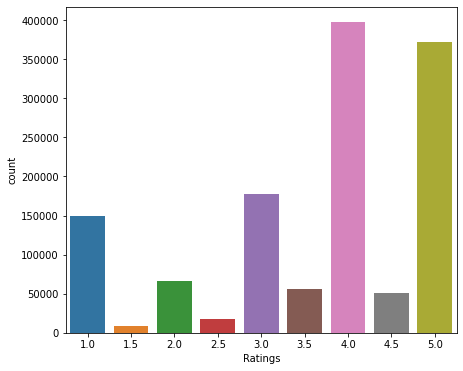

In [ ]:
import seaborn as sns

#distribution of ratings
plt.figure(figsize=(7,6))
rating=rating_df['rating'].value_counts()
sns.barplot(x=rating.index,y=rating)
plt.xlabel("Ratings")
plt.ylabel('count')

# Sentiment Analysis:

In [ ]:
#map reviews to negative if the rating given is less than 2.5 and positive if rating is greater than 2.5
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#tokenize the data and vectorize the reviews to feed it to our model
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(rating_df['review'].values)
X = tokenizer.texts_to_sequences(rating_df['review'].values)
X = pad_sequences(X)

# Building LSTM model:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 112, 32)           96000     
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 104,386
Trainable params: 104,386
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#train-test split:
Y = pd.get_dummies(rating_df['sent'].astype(int)).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(868218, 112) (868218, 2)
(427631, 112) (427631, 2)


In [26]:
#fitting our model
batch_size = 3200
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size)

Epoch 1/5
272/272 [==============================] - 193s 695ms/step - loss: 0.2498 - accuracy: 0.8990
Epoch 2/5
272/272 [==============================] - 188s 691ms/step - loss: 0.1605 - accuracy: 0.9371
Epoch 3/5
272/272 [==============================] - 189s 695ms/step - loss: 0.1466 - accuracy: 0.9432
Epoch 4/5
272/272 [==============================] - 190s 699ms/step - loss: 0.1316 - accuracy: 0.9497
Epoch 5/5
272/272 [==============================] - 187s 688ms/step - loss: 0.1212 - accuracy: 0.9541


# Evaluation:

In [27]:
#taking 1500 rows to validate our model
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

134/134 - 8s - loss: 0.1151 - accuracy: 0.9572 - 8s/epoch - 56ms/step
score: 0.12
acc: 0.96
